# Contextual Policies

Analyze the performance of our Whittle and Adaptive Policies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import json 
import argparse 
import sys
import secrets
from itertools import combinations
import gurobipy as gp
from gurobipy import GRB

In [3]:
import sys
sys.path.append('/usr0/home/naveenr/projects/food_rescue_preferences')

In [4]:
from rmab.simulator import run_multi_seed
from rmab.whittle_policies import *
from rmab.baseline_policies import *
from rmab.mcts_policies import *
from rmab.utils import get_save_path, delete_duplicate_results, restrict_resources

In [5]:
is_jupyter = 'ipykernel' in sys.modules

In [6]:
if is_jupyter: 
    seed        = 50
    n_arms      = 4
    volunteers_per_arm = 1
    budget      = 2
    discount    = 0.9
    alpha       = 3 
    n_episodes  = 105
    episode_len = 50 
    n_epochs    = 1
    save_with_date = False 
    lamb = 0.5
    prob_distro = 'uniform'
    reward_type = "linear"
    reward_parameters = {'universe_size': 20, 'arm_set_low': 0, 'arm_set_high': 1}
    out_folder = 'iterative'
    time_limit = 100
    context_dim = n_arms*volunteers_per_arm
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_arms',         '-N', help='num beneficiaries (arms)', type=int, default=2)
    parser.add_argument('--volunteers_per_arm',         '-V', help='volunteers per arm', type=int, default=5)
    parser.add_argument('--episode_len',    '-H', help='episode length', type=int, default=50)
    parser.add_argument('--n_episodes',     '-T', help='num episodes', type=int, default=105)
    parser.add_argument('--budget',         '-B', help='budget', type=int, default=3)
    parser.add_argument('--n_epochs',       '-E', help='number of epochs (num_repeats)', type=int, default=1)
    parser.add_argument('--discount',       '-d', help='discount factor', type=float, default=0.9)
    parser.add_argument('--alpha',          '-a', help='alpha: for conf radius', type=float, default=3)
    parser.add_argument('--lamb',          '-l', help='lambda for matching-engagement tradeoff', type=float, default=0.5)
    parser.add_argument('--universe_size', help='For set cover, total num unvierse elems', type=int, default=10)
    parser.add_argument('--arm_set_low', help='Least size of arm set, for set cover', type=float, default=3)
    parser.add_argument('--arm_set_high', help='Largest size of arm set, for set cover', type=float, default=6)
    parser.add_argument('--reward_type',          '-r', help='Which type of custom reward', type=str, default='set_cover')
    parser.add_argument('--seed',           '-s', help='random seed', type=int, default=42)
    parser.add_argument('--prob_distro',           '-p', help='which prob distro [uniform,uniform_small,uniform_large,normal]', type=str, default='uniform')
    parser.add_argument('--out_folder', help='Which folder to write results to', type=str, default='iterative')
    parser.add_argument('--time_limit', help='Online time limit for computation', type=float, default=100)
    parser.add_argument('--use_date', action='store_true')

    args = parser.parse_args()

    n_arms      = args.n_arms
    volunteers_per_arm = args.volunteers_per_arm
    budget      = args.budget
    discount    = args.discount
    alpha       = args.alpha 
    seed        = args.seed
    n_episodes  = args.n_episodes
    episode_len = args.episode_len
    n_epochs    = args.n_epochs
    lamb = args.lamb
    save_with_date = args.use_date
    prob_distro = args.prob_distro
    out_folder = args.out_folder
    reward_type = args.reward_type
    reward_parameters = {'universe_size': args.universe_size,
                        'arm_set_low': args.arm_set_low, 
                        'arm_set_high': args.arm_set_high}
    time_limit = args.time_limit 
    context_dim = n_arms*volunteers_per_arm

save_name = secrets.token_hex(4)  

In [7]:
results = {}
results['parameters'] = {'seed'      : seed,
        'n_arms'    : n_arms,
        'volunteers_per_arm': volunteers_per_arm, 
        'budget'    : budget,
        'discount'  : discount, 
        'alpha'     : alpha, 
        'n_episodes': n_episodes, 
        'episode_len': episode_len, 
        'n_epochs'  : n_epochs, 
        'lamb': lamb,
        'prob_distro': prob_distro, 
        'reward_type': reward_type, 
        'universe_size': reward_parameters['universe_size'],
        'arm_set_low': reward_parameters['arm_set_low'], 
        'arm_set_high': reward_parameters['arm_set_high'],
        'time_limit': time_limit, 
        'context_dim': context_dim,
        } 

## Non-RMAB Max Problem

In [106]:
N = 10
K = 3
T = 50
np.random.seed(42)
context_dim = 1
max_values = np.array([np.random.random() for i in range(N)])
hidden_contexts = np.array([[np.random.randint(0,2) for i in range(N)] for t in range(T)])
hidden_contexts[-1] = [1 for i in range(N)]
sum_of_top_k = lambda numbers, k: np.sum(np.sort(numbers)[-k:])
best_score = np.array([sum_of_top_k(max_values*h,K) for h in hidden_contexts])
best_score

array([2.30624267, 1.48667107, 2.04118153, 1.70536731, 1.46518211,
       2.52496303, 2.2599019 , 2.54888439, 2.54888439, 2.1992851 ,
       2.04118153, 0.37454012, 2.038725  , 1.73024324, 2.038725  ,
       1.12921724, 1.49815013, 1.08025428, 2.41800546, 0.65919862,
       2.19682857, 2.54888439, 1.26252858, 2.1992851 , 1.97288497,
       2.54888439, 2.39078083, 1.4627497 , 2.17536374, 1.81460664,
       2.04118153, 2.04118153, 2.41800546, 1.83937475, 1.83937475,
       2.28382326, 2.05724837, 2.1992851 , 2.52496303, 2.54888439,
       2.54888439, 2.41554894, 2.52496303, 2.54888439, 1.81460664,
       2.52496303, 2.41554894, 2.17290721, 1.90784607, 2.54888439])

In [98]:
def f(arm_context,context,action,arm_num):
    return arm_context*action*context[arm_num]

def g(y_list):
    return sum(y_list)

In [99]:
value_list = []
action_list = []
for _ in range(T):
    random_context = hidden_contexts[_]

    # Create a new model
    model = gp.Model("linear_program")
    model.setParam('OutputFlag', 0)
    model.params.Seed = 42
    # Add variables
    b = model.addVars(context_dim,lb=0,ub=1,name="b")

    yp = model.addVars(N,lb=0,ub=1,name="yp")
    u = model.addVars(N,context_dim,lb=0,ub=1,name="u")
    xu = model.addVars(N,context_dim,lb=0,ub=1,name="xu")
    x = model.addVars(N,lb=0,ub=1,name="x",vtype=gp.GRB.BINARY)

    model.setObjective(gp.quicksum(b[i] for i in range(context_dim)) + gp.quicksum(u[i,0]*0.001+0.001*xu[i,0] for i in range(N)), GRB.MAXIMIZE)

    # Add constraints
    for j in range(context_dim):
        model.addConstr(b[j] <= gp.quicksum(xu[i,j]*random_context[i] for i in range(N)))

        for i in range(N):
            model.addConstr(b[j] >= xu[i,j]*random_context[i],"c1_{}_{}".format(i,j))

            # TODO: Remove these constaints in general; for maximum
            model.addConstr(b[j] <= 1 + xu[i,j]*random_context[i] - yp[i])

            model.addConstr(xu[i,j] <= x[i], f"c2_{i}_{j}")
            model.addConstr(xu[i,j] <= u[i,j], f"c4_{i}_{j}")
            model.addConstr(xu[i,j] >= u[i,j] + x[i] - 1, f"c5_{i}_{j}")
            model.addConstr(xu[i,j] >= 0, f"c3_{i}_{j}")
            model.addConstr(xu[i,j] <= 1, f"c7_{i}_{j}")

    # TODO: Remove this constraint; for the maximum
    model.addConstr(gp.quicksum(yp[i] for i in range(N)) == 1)


    model.addConstr(gp.quicksum(x[i] for i in range(N)) == K, "sum_z_constraint")

    for constraint_num in range(len(value_list)):
        yprime = model.addVars(N,lb=0,ub=1,name="yp_{}".format(constraint_num))

        for i in range(N):
            model.addConstr(u[i,0]*hidden_contexts[constraint_num][i]*action_list[constraint_num][i] <= value_list[constraint_num],"c1_{}".format(i))

            # TODO: Remove these constaints in general; for maximum
            model.addConstr(1 + u[i,0]*hidden_contexts[constraint_num][i]*action_list[constraint_num][i] - yprime[i] >= value_list[constraint_num])

        model.addConstr(gp.quicksum(yprime[i] for i in range(N)) == 1)


    # Optimize the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        print("u values:", [u[j,0].X for j in range(N)])

    action = [int(x[j].X) for j in range(N)]

    y_values = [f(max_values[i],random_context,action[i],i) for i in range(N)]
    value = g(y_values)

    print("Real value {}".format(value))
    print("Optimal value {}".format(best_score[_]))
    print("Context {}".format(random_context))
    print("Action {}".format(action))

    value_list.append(value)
    action_list.append(action)

u values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Real value 1.3091875895392544
Optimal value 0.8661761457749352
Context [1 0 1 1 1 1 1 1 1 1]
Action [0, 1, 0, 0, 0, 0, 0, 0, 1, 1]


AttributeError: Unable to retrieve attribute 'X'

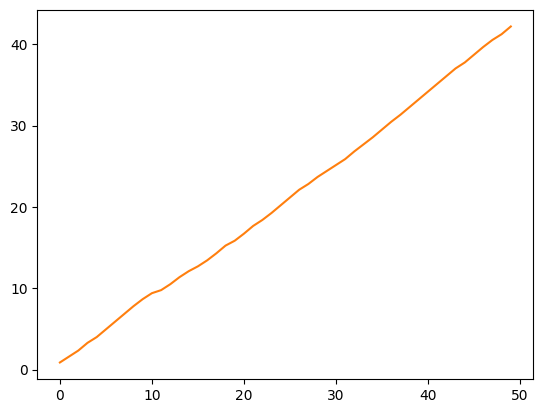

In [100]:
plt.plot(np.cumsum(value_list),label="Ours")
plt.plot(np.cumsum(best_score),label="Oracle")

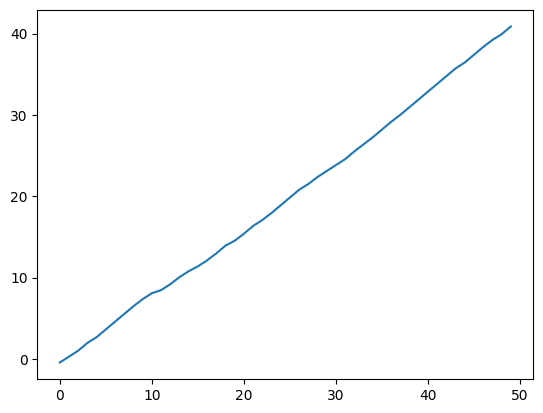

In [101]:
plt.plot(np.cumsum(best_score)-np.cumsum(value_list))

In [107]:
value_list = []
action_list = []
for _ in range(T):
    random_context = hidden_contexts[_]

    # Create a new model
    model = gp.Model("linear_program")
    model.setParam('OutputFlag', 0)
    model.params.Seed = 42
    # Add variables
    b = model.addVars(context_dim,lb=0,ub=1,name="b")
    u = model.addVars(N,context_dim,lb=0,ub=1,name="u")
    xu = model.addVars(N,context_dim,lb=0,ub=1,name="xu")
    x = model.addVars(N,lb=0,ub=1,name="x",vtype=gp.GRB.BINARY)

    model.setObjective(gp.quicksum(b[i] for i in range(context_dim)) + gp.quicksum(u[i,0]*0.001+0.001*xu[i,0] for i in range(N)), GRB.MAXIMIZE)

    # Add constraints
    for j in range(context_dim):
        model.addConstr(b[j] <= gp.quicksum(xu[i,j]*random_context[i] for i in range(N)))

        for i in range(N):
            model.addConstr(b[j] >= xu[i,j]*random_context[i],"c1_{}_{}".format(i,j))

            model.addConstr(xu[i,j] <= x[i], f"c2_{i}_{j}")
            model.addConstr(xu[i,j] <= u[i,j], f"c4_{i}_{j}")
            model.addConstr(xu[i,j] >= u[i,j] + x[i] - 1, f"c5_{i}_{j}")
            model.addConstr(xu[i,j] >= 0, f"c3_{i}_{j}")
            model.addConstr(xu[i,j] <= 1, f"c7_{i}_{j}")


    model.addConstr(gp.quicksum(x[i] for i in range(N)) == K, "sum_z_constraint")

    for constraint_num in range(len(value_list)):
        for i in range(N):
            model.addConstr(u[i,0]*hidden_contexts[constraint_num][i]*action_list[constraint_num][i] <= value_list[constraint_num],"c1_{}".format(i))

        model.addConstr(gp.quicksum(u[i,0]*hidden_contexts[constraint_num][i]*action_list[constraint_num][i] for i in range(N)) >= value_list[constraint_num])


    # Optimize the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        print("u values:", [u[j,0].X for j in range(N)])

    action = [int(x[j].X) for j in range(N)]

    y_values = [f(max_values[i],random_context,action[i],i) for i in range(N)]
    value = g(y_values)

    print("Real value {}".format(value))
    print("Optimal value {}".format(best_score[_]))
    print("Context {}".format(random_context))
    print("Action {}".format(action))

    value_list.append(value)
    action_list.append(action)

u values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Real value 1.3091875895392544
Optimal value 2.3062426653823858
Context [1 0 1 1 1 1 1 1 1 1]
Action [0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
u values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Real value 1.3887360381766412
Optimal value 1.4866710664508782
Context [0 0 1 1 1 0 1 0 0 0]
Action [0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
u values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Real value 0.9106716449756758
Optimal value 2.0411815313506594
Context [0 0 1 1 1 1 1 0 1 1]
Action [0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
u values: [1.0, 1.0, 1.0, 0.9106716449756758, 0.9106716449756758, 0.9106716449756758, 1.0, 1.0, 1.0, 1.0]
Real value 0.05808361216819946
Optimal value 1.7053673109431555
Context [0 1 0 1 0 1 1 0 0 0]
Action [1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
u values: [1.0, 1.0, 1.0, 0.9106716449756758, 0.9106716449756758, 0.9106716449756758, 0.05808361216819946, 1.0, 1.0, 1.0]
Real value 0.6011150117432088
Optimal value 1.465182109875457
Co

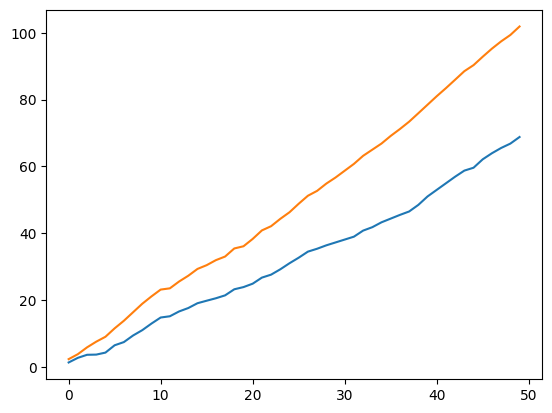

In [108]:
plt.plot(np.cumsum(value_list),label="Ours")
plt.plot(np.cumsum(best_score),label="Oracle")

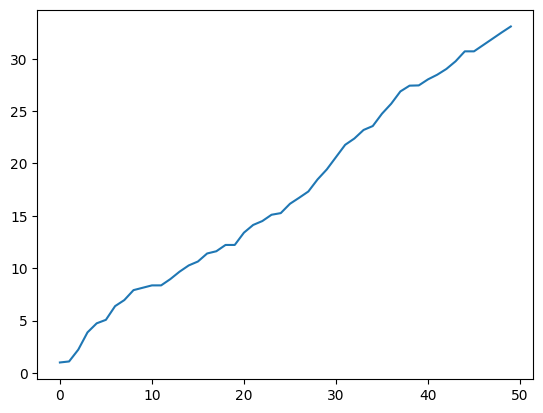

In [109]:
plt.plot(np.cumsum(best_score)-np.cumsum(value_list))

In [110]:
value_list = []
action_list = []
for _ in range(T):
    random_context = hidden_contexts[_]

    # Create a new model
    model = gp.Model("linear_program")
    model.setParam('OutputFlag', 0)
    model.params.Seed = 42
    # Add variables
    u = model.addVars(N,lb=0,ub=1,name="u")
    xu = model.addVars(N,lb=0,ub=1,name="xu")
    x = model.addVars(N,lb=0,ub=1,name="x",vtype=gp.GRB.BINARY)

    model.setObjective(gp.quicksum(xu[i]*random_context[i]+0.001*u[i] for i in range(N)), GRB.MAXIMIZE)

    # Add constraints
    for i in range(N):
        model.addConstr(xu[i] <= x[i], f"c2_{i}")
        model.addConstr(xu[i] <= u[i], f"c4_{i}")
        model.addConstr(xu[i] >= u[i] + x[i] - 1, f"c5_{i}")
        model.addConstr(xu[i] >= 0, f"c3_{i}")
        model.addConstr(xu[i] <= 1, f"c7_{i}")
        model.addConstr(u[i] <= 1, f"c8_{i}")
        model.addConstr(u[i] >= 0, f"c9_{i}")
    model.addConstr(gp.quicksum(x[i] for i in range(N)) == K, "sum_z_constraint")

    for constraint_num in range(len(value_list)):
        model.addConstr(gp.quicksum(u[i]*hidden_contexts[constraint_num][i]*action_list[constraint_num][i] for i in range(N)) <= value_list[constraint_num])


    # Optimize the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        print("u values:", [u[j].X for j in range(N)])

    action = [int(x[j].X) for j in range(N)]

    y_values = [f(max_values[i],random_context,action[i],i) for i in range(N)]
    value = g(y_values)

    print("Real value {}".format(value))
    print("Optimal value {}".format(best_score[_]))
    print("Context {}".format(random_context))
    print("Action {}".format(action))

    value_list.append(value)
    action_list.append(action)

u values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Real value 1.8146066384548132
Optimal value 2.3062426653823858
Context [1 0 1 1 1 1 1 1 1 1]
Action [1, 0, 1, 0, 0, 0, 0, 0, 0, 1]
u values: [0.8146066384548132, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
Real value 0.8127607368076726
Optimal value 1.4866710664508782
Context [0 0 1 1 1 0 1 0 0 0]
Action [0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
u values: [0.8146066384548132, 1.0, 1.0, 0.8127607368076726, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]
Real value 1.4891034738908164
Optimal value 2.0411815313506594
Context [0 0 1 1 1 1 1 0 1 1]
Action [0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
u values: [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.8127607368076726, 1.0, 0.48910347389081643, 0.8146066384548132]
Real value 1.1647924389143185
Optimal value 1.7053673109431555
Context [0 1 0 1 0 1 1 0 0 0]
Action [0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
u values: [0.8146066384548132, 0.0, 0.0, 0.0, 0.0, 0.3520317021066459, 0.8127607368076726, 1.0, 1.0, 1.0]
Real value 1.3672712017074538
Optim

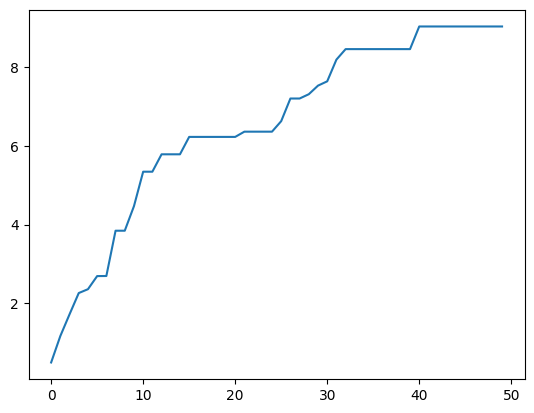

In [111]:
plt.plot(np.cumsum(best_score)-np.cumsum(value_list))

In [112]:
value_list = []
action_list = []
for _ in range(T):
    random_context = hidden_contexts[_]

    # Create a new model
    model = gp.Model("linear_program")
    model.setParam('OutputFlag', 0)
    model.params.Seed = 42
    # Add variables
    u = model.addVars(N,lb=0,ub=1,name="u")
    xu = model.addVars(N,lb=0,ub=1,name="xu")
    x = model.addVars(N,lb=0,ub=1,name="x",vtype=gp.GRB.BINARY)

    model.setObjective(gp.quicksum(xu[i]*random_context[i]+0.001*u[i] for i in range(N)), GRB.MAXIMIZE)

    # Add constraints
    for i in range(N):
        model.addConstr(xu[i] <= x[i], f"c2_{i}")
        model.addConstr(xu[i] <= u[i], f"c4_{i}")
        model.addConstr(xu[i] >= u[i] + x[i] - 1, f"c5_{i}")
        model.addConstr(xu[i] >= 0, f"c3_{i}")
        model.addConstr(xu[i] <= 1, f"c7_{i}")
        model.addConstr(u[i] <= 1, f"c8_{i}")
        model.addConstr(u[i] >= 0, f"c9_{i}")
    model.addConstr(gp.quicksum(x[i] for i in range(N)) == K, "sum_z_constraint")

    for constraint_num in range(len(value_list)):
        model.addConstr(gp.quicksum(u[i]*hidden_contexts[constraint_num][i]*action_list[constraint_num][i] for i in range(N)) >= value_list[constraint_num])

        for i in range(N):
            model.addConstr(u[i]*hidden_contexts[constraint_num][i]*action_list[constraint_num][i] <= value_list[constraint_num])

    # Optimize the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        print("u values:", [u[j].X for j in range(N)])

    action = [int(x[j].X) for j in range(N)]

    y_values = [f(max_values[i],random_context,action[i],i) for i in range(N)]
    value = g(y_values)

    print("Real value {}".format(value))
    print("Optimal value {}".format(best_score[_]))
    print("Context {}".format(random_context))
    print("Action {}".format(action))

    value_list.append(value)
    action_list.append(action)

u values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Real value 1.8146066384548132
Optimal value 2.3062426653823858
Context [1 0 1 1 1 1 1 1 1 1]
Action [1, 0, 1, 0, 0, 0, 0, 0, 0, 1]
u values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Real value 1.486671066450878
Optimal value 1.4866710664508782
Context [0 0 1 1 1 0 1 0 0 0]
Action [0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
u values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Real value 0.9106716449756758
Optimal value 2.0411815313506594
Context [0 0 1 1 1 1 1 0 1 1]
Action [0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
u values: [1.0, 1.0, 1.0, 0.9106716449756758, 0.9106716449756758, 0.9106716449756758, 1.0, 1.0, 1.0, 1.0]
Real value 1.6074564027751523
Optimal value 1.7053673109431555
Context [0 1 0 1 0 1 1 0 0 0]
Action [0, 1, 0, 1, 0, 0, 1, 0, 0, 0]
u values: [1.0, 1.0, 1.0, 0.9106716449756758, 0.9106716449756758, 0.9106716449756758, 1.0, 1.0, 1.0, 1.0]
Real value 1.3672712017074538
Optimal value 1.465182109875457
Context [0 0 0 0 0 1

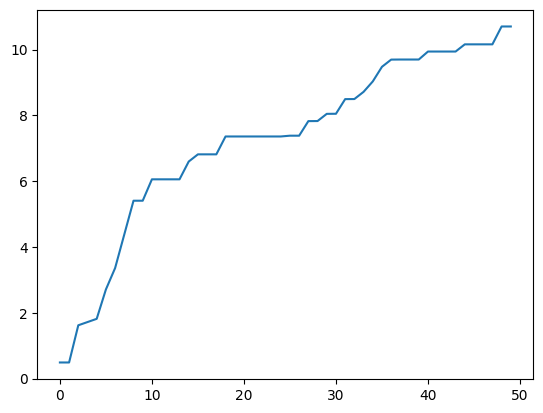

In [113]:
plt.plot(np.cumsum(best_score)-np.cumsum(value_list))

## Non-RMAB Subset Problem

In [68]:
N = 10
K = 3
context_size = 3
T = 200
random.seed(42)
hidden_contexts = [[random.randint(0,1) for i in range(context_size)] for _ in range(N)]
hidden_contexts = np.array(hidden_contexts)
arm_rewards = []

upper_bounds = np.array([[1 for i in range(context_size)] for _ in range(N)])

In [69]:
N = len(upper_bounds)
value_list = []
action_list = []
rand_context_list = []

max_values = [] 

np.random.seed(42)
random.seed(42)

for _ in range(T):
    rand_context = [random.randint(0,1) for i in range(context_size)]
    # Create a new model
    model = gp.Model("linear_program")
    model.params.Seed = 42
    # Add variables
    z = model.addVars(len(rand_context), lb=0, ub=1, name="z")
    x = model.addVars(N, lb=0, ub=1, name="x")
    A = model.addVars(N,len(rand_context), lb=0, ub=1, name="A")
    B = model.addVars(N,len(rand_context), lb=0, ub=1, name="B")

    # Set the objective function
    model.setObjective(gp.quicksum(z[i] * rand_context[i] for i in range(len(rand_context))), GRB.MAXIMIZE)

    # Add constraints
    for i in range(len(rand_context)):
        for j in range(N):
            model.addConstr(z[i] >= A[j,i], f"c1_{i}_{j}")
            model.addConstr(A[j,i] <= x[j], f"c2_{i}_{j}")
            model.addConstr(A[j,i] >= 0, f"c3_{i}_{j}")
            model.addConstr(A[j,i] <= B[j,i], f"c4_{i}_{j}")
            model.addConstr(A[j,i] >= B[j,i] + x[j] - 1, f"c5_{i}_{j}")
            model.addConstr(B[j,i] >= 0, f"c6_{i}_{j}")
            model.addConstr(B[j,i] <= 1, f"c7_{i}_{j}")

        model.addConstr(z[i] <= gp.quicksum(A[j,i] for j in range(N)), f"c8_{i}")
    # Add the additional constraint: sum z[i] <= K
    model.addConstr(gp.quicksum(x[i] for i in range(N)) == K, "sum_z_constraint")

    for constraint_num in range(len(value_list)):
        z_hat = model.addVars(len(rand_context), lb=0, ub=1, name="z_hat_{}".format(constraint_num))

        for i in range(len(rand_context)):
            for j in range(N):
                model.addConstr(z_hat[i] >= action_list[constraint_num][j]*B[j,i], f"c1_{i}_{j}")
            model.addConstr(z_hat[i] <= gp.quicksum(action_list[constraint_num][j]*B[j,i] for j in range(N)), f"c8_{i}")
        model.addConstr(gp.quicksum(z_hat[j]*rand_context_list[constraint_num][j] for j in range(len(rand_context))) <= value_list[constraint_num], f"c8_{i}")

    # Optimize the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        print("Optimal objective value:", model.objVal)
        print("z values:", [z[i].X for i in range(len(rand_context))])
        print("x values:", [x[j].X for j in range(N)])

    action = [int(x[j].X) for j in range(N)]

    if len(hidden_contexts[np.array(action) == 1]) > 0:
        max_coverage = np.max(hidden_contexts[np.array(action) == 1],axis=0)
        value = np.sum(max_coverage.dot(rand_context))
    else:
        value = 0

    value_list.append(value)
    action_list.append(action)
    rand_context_list.append(rand_context)
    max_values.append(sum(rand_context))

Set parameter Seed to value 42
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700K CPU @ 4.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 214 rows, 73 columns and 403 nonzeros
Model fingerprint: 0x836e2f77
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 150 rows and 30 columns
Presolve time: 0.00s
Presolved: 64 rows, 43 columns, 163 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   3.000000e+00   0.000000e+00      0s
       3    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.000000000e+00
Optimal objective value: 1.0
z values: [0.0, 0.0, 1.0]
x values: [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.

Presolve removed 275 rows and 11 columns
Presolve time: 0.00s
Presolved: 177 rows, 83 columns, 445 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+00   8.000000e+00   0.000000e+00      0s
      22    2.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.000000000e+00
Optimal objective value: 2.0
z values: [0.0, 1.0, 1.0]
x values: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Set parameter Seed to value 42
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700K CPU @ 4.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 486 rows, 97 columns and 818 nonzeros
Model fingerprint: 0x6986d693
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        

In [72]:
np.mean(max_values),np.mean(value_list)

(1.47, 1.035)